
## This notebook compares ID samples with their corresponding pseudo OOD samples in regards to their feature distributions (&sect; 4.5.1). <br>

In [1]:
import nltk
import torch
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk.corpus import stopwords
import nlpaug.augmenter.word as naw
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.sentiment.vader import SentimentIntensityAnalyzer

random.seed(24)
warnings.filterwarnings('ignore')
# nltk.download('punkt')

<b>VERSION:</b><br><br>

<li>nltk == 3.5</li>
<li>torch == 1.8.1+cu111</li>
<li>numpy == 1.21.6</li>
<li>pandas == 1.3.4</li>
<li>seaborn == 0.11.1</li>
<li>matplotlib == 3.4.2</li>
<li>datasets == 2.7.1</li>
<li>nlpaug == 1.1.10</li>
<li>gensim == 3.8.3</li>

## 0 &emsp; Helper Functions

In [2]:
# Load SST2 dataset.
def load_sst2():
    datasets = load_dataset('glue', 'sst2', cache_dir="./cache/sst2/")
    training_set = datasets['train']
    dev_set = datasets['validation']
    test_set = datasets['test']
    return training_set, dev_set, test_set

## 1 &emsp; SST2 Dataset

### 1.1 &emsp; Loading SST2 Dataset

In [3]:
training_set, dev_set, test_set = load_sst2()

Found cached dataset glue (/home/jupyter-hanyu/projects/OOD/released/./cache/sst2/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

### 1.2 &emsp; Data Sampling

In [4]:
# We sample 20K examples from the training set of the entire SST2 dataset as the ID samples.
indices = list(range(training_set.num_rows))
random.shuffle(indices)
ID_sentences= list(np.array(training_set['sentence'])[indices[:20000]])
ID_lables = list(np.array(training_set['label'])[indices[:20000]])

# We select 10K ID samples based on which we generate their corresponding pseudo OOD samples.
ID_sentences_for_OOD = ID_sentences[:10000]
ID_labels_for_OOD = ID_lables[:10000]
ID_sentences_reserved = ID_sentences[10000:]
ID_labels_reserved = ID_lables[10000:]

## 2 &emsp; Semantic Feature Distribution

### 2.1 &emsp; Generating Pseudo OOD Samples

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Please refer to https://github.com/makcedward/nlpaug for the detailed documentation. 
generator = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', # We use DistilBERT as the generator.
                                action='substitute',
                                aug_p=0.7, # We set the replacement ratio to 0.7.
                                top_k=100, # The candidate size is set to 100.
                                stopwords=stopwords.words('english'), # We do not substitute stopwords.
                                device=str(device),
                                )
# Pseudo OOD generation.
pseudo_oods = []
for ids in ID_sentences_for_OOD:
    pseudo_oods.append(generator.augment(ids))

# Saving.
with open("./data/pseudo_oods.txt", 'w') as output:
    for ood in pseudo_oods:
        output.write(str(ood) + '\n')

### 2.2 &emsp; Calculating Polarity Scores

In [6]:
# Calculating polarity scores for the ID samples.
ID_scores = []
for sentence in ID_sentences:
    score = SentimentIntensityAnalyzer().polarity_scores(sentence)['compound']
    ID_scores.append(score)
    
# Calculating polarity scores for the pseudo OOD samples.
OOD_scores = []
for sentence in pseudo_oods:
    score = SentimentIntensityAnalyzer().polarity_scores(sentence)['compound']
    OOD_scores.append(score)

# Dataframe.
df_scores = pd.DataFrame()
label_map = {'0': 'id', '1': 'pseudo_ood'}
df_scores['polarity_score'] = ID_scores + OOD_scores
df_scores['source'] = len(ID_scores)*[0] + len(OOD_scores)*[1]
df_scores['source'] = df_scores['source'].astype(str)
df_scores = df_scores.replace({'source': label_map})

df_scores

,polarity_score,source
0,0.4926,id
1,-0.4019,id
2,0.3612,id
3,0.0000,id
4,0.0000,id
...,...,...
29995,0.9493,pseudo_ood
29996,-0.6602,pseudo_ood
29997,0.0697,pseudo_ood
29998,0.0000,pseudo_ood


### 2.3 &emsp; Visualization

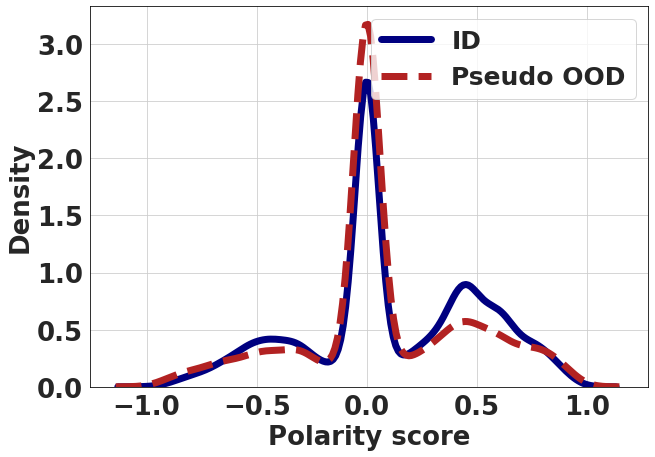

In [7]:
# Settings.
sns.set_style("whitegrid")
sns.set_style({'axes.facecolor': 'white', 'axes.edgecolor': 'black', 'axes.grid': True})
plt.rcParams["figure.figsize"] = (10,7)

# Plot.
ax = sns.kdeplot(data=df_scores[df_scores.source=='id'], x="polarity_score", linewidth=7, color='navy')
ax = sns.kdeplot(data=df_scores[df_scores.source=='pseudo_ood'], x="polarity_score", linewidth=7, linestyle="--",color='firebrick')
plt.legend(["ID", "Pseudo OOD"], prop={'size': 25, 'weight':'bold'}, loc='best')
plt.xlabel('Polarity score', fontsize=26, weight='bold')
plt.ylabel('Density', fontsize=26, weight='bold')
plt.xticks(size=26, weight='bold')
plt.yticks(size=26, weight='bold')
plt.show()

# Saving.
ax.figure.savefig("./figures/semantic_feature_distribution.png")

## 3 &emsp; Background Feature Distribution

### 3.1 &emsp; Generating Pseudo OOD Samples

In [8]:
# Pseudo OOD generation.
pseudo_oods_2 = []
for ids in ID_sentences_reserved:
    pseudo_oods_2.append(generator.augment(ids))

# Saving.
with open("./data/pseudo_oods_2.txt", 'w') as output:
    for ood in pseudo_oods_2:
        output.write(str(ood) + '\n')

### 3.2 &emsp; Doc2Vec Training

In [9]:
# Tokenization.
ID_training = ID_sentences_for_OOD
tokenized_sentences = []
for s in ID_training:
    tokenized_sentences.append(word_tokenize(s.lower()))

# Training.
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sentences)]
model = Doc2Vec(tagged_data, vector_size = 30, window = 2, min_count = 1, epochs = 100)

### 3.3 &emsp; Calculating Similarity Scores

In [10]:
# For ID reserved samples.
ID_similarities = []
for query in ID_sentences_reserved:
    query_tokenized = word_tokenize(query.lower())
    query_vector = model.infer_vector(query_tokenized)
    similarity_score = model.docvecs.most_similar(positive = [query_vector], topn=1)[0][1]
    ID_similarities.append(similarity_score)

# For pseudo OOD samples.
OOD_similarities = []
for query in pseudo_oods_2:
    query_tokenized = word_tokenize(query.lower())
    query_vector = model.infer_vector(query_tokenized)
    similarity_score = model.docvecs.most_similar(positive = [query_vector], topn=1)[0][1]
    OOD_similarities.append(similarity_score)
    
    
# Dataframe.
label_map = {'0': 'id', '1': 'pseudo_ood'}
df_similarity = pd.DataFrame()
df_similarity['similarity_score'] = ID_similarities + OOD_similarities
df_similarity['source'] = [0]*len(ID_similarities) + [1]*len(OOD_similarities)
df_similarity['source'] = df_similarity['source'].astype(str)
df_similarity = df_similarity.replace({'source': label_map})

df_similarity

,similarity_score,source
0,0.781415,id
1,0.714359,id
2,0.608422,id
3,0.823968,id
4,0.640648,id
...,...,...
19995,0.907310,pseudo_ood
19996,0.910558,pseudo_ood
19997,0.602715,pseudo_ood
19998,0.722698,pseudo_ood


### 3.4 &emsp; Visualization

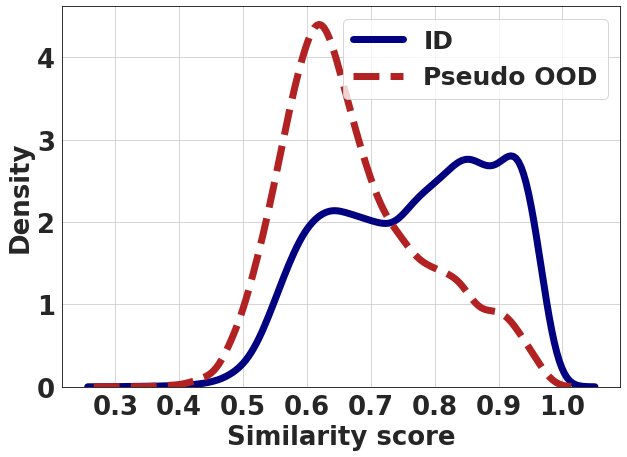

In [11]:
# Settings.
sns.set_style("whitegrid")
sns.set_style({'axes.facecolor': 'white', 'axes.edgecolor': 'black', 'axes.grid': True})
plt.rcParams["figure.figsize"] = (10,7)

ax = sns.kdeplot(data=df_similarity[df_similarity.source=='id'], x="similarity_score", linewidth=7, color='navy')
ax = sns.kdeplot(data=df_similarity[df_similarity.source=='pseudo_ood'], x="similarity_score", linewidth=7, linestyle="--", color='firebrick')
plt.legend(["ID", "Pseudo OOD"], prop={'size': 25, 'weight':'bold'}, loc='best')

plt.xlabel("Similarity score", fontsize=26, weight='bold')
plt.ylabel("Density", fontsize=26, weight='bold')
plt.xticks(fontsize=26, weight='bold')
plt.yticks(fontsize=26, weight='bold')
plt.show()

# Saving.
ax.figure.savefig("./figures/background_feature_distribution.png")